# Case\_10

- `Case_10`: Global two-exponential profile

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import FortranFile
cluz=2.99793E8
pi=np.pi
R2d=180.0/np.pi 
nlp=12    # Link lines number
ncamp=6   # Field components

In [2]:
# Spheric and cartesian coordinate functions
# Angles in radians

def esf2car(cE):
    r,th,ph= cE
    x= r*np.sin(th)*np.cos(ph)
    y= r*np.sin(th)*np.sin(ph)
    z= r*np.cos(th)
    return np.array([x,y,z])

def car2esf(cX):
    x,y,z= cX
    r= np.sqrt(x**2+y**2+z**2)
    th= np.arctan2(np.sqrt(x**2+y**2),z)
    ph= np.arctan2(y,x)
    return np.array([r,th,ph])

def esf2carV(fE,th,ph):
    fr,fth,fph= fE
    fC=np.zeros(3,dtype=float)
    fC[0]= np.sin(th)*np.cos(ph)*fr+np.cos(th)*np.cos(ph)*fth-np.sin(ph)*fph
    fC[1]= np.sin(th)*np.sin(ph)*fr+np.cos(th)*np.sin(ph)*fth+np.cos(ph)*fph
    fC[2]= np.cos(th)*fr-np.sin(th)*fth
    return fC

def car2esfV(fX,th,ph):
    fx,fy,fz= fX
    fE=np.zeros(3,dtype=float)
    fE[0]=np.sin(th)*np.cos(ph)*fx+np.sin(th)*np.sin(ph)*fy+np.cos(th)*fz
    fE[1]=np.cos(th)*np.cos(ph)*fx+np.cos(th)*np.sin(ph)*fy-np.sin(th)*fz
    fE[2]=-np.sin(ph)*fx+np.cos(ph)*fy
    return fE

In [3]:
def cambia(coo):                   # Nearest node center coordinate
    celda=np.floor(coo/dl)+1   
    coon=(celda-0.5)*dl-ra2   
    coones=car2esf(coon)
    return(coones)   


def readvoltages(case):                              # Voltages reading
    f2 = FortranFile(case+'/'+'voltages_box', 'r')
    lisvolint=f2.read_record(dtype=np.float32)
    f2.close()
    volint=lisvolint.reshape(ninter,nsal,ncamp)
    volintesf=np.zeros((nsal,ncamp,ninter))
    vimod=np.zeros((nsal,2,ninter))
    vointer=np.zeros(3)
    for i in range(ninter):
        for j in range(nsal):
            coones=cambia(salcoo[j,:])
            vointer=car2esfV(volint[i,j,0:3],coones[1],coones[2])
            volintesf[j,0:3,i]=vointer
            vimod[j,0,i]=np.sqrt(np.sum(vointer**2))
            vointer=car2esfV(volint[i,j,3:6],coones[1],coones[2])
            volintesf[j,3:6,i]=vointer
            vimod[j,1,i]=np.sqrt(np.sum(vointer**2))
    return volintesf, vimod

def location():              # Nearest node center coordinates for feeding points
    print('Feeding points')
    for j in range(nali):
        cooali=alicoo[j,:]-ra2
        cooaliesf=car2esf(cooali)
        print('Input h={0:6.1F} km theta={1:4.1F} deg phi= {2:4.1F} deg'.\
              format(cooaliesf[0]*1e-3,cooaliesf[1]*R2d,cooaliesf[2]*R2d))
        coones=cambia(alicoo[j,:])
        print('Code  h={0:6.1F} km theta={1:4.1F} deg phi= {2:4.1F} deg'.\
              format(coones[0]*1e-3,coones[1]*R2d,coones[2]*R2d))
    print('Output points')    # Nearest node center coordinates for outputs points
    for j in range(nsal):
        coosal=salcoo[j,:]-ra2
        coosalesf=car2esf(coosal)
        print('Input h={0:6.1F} km theta={1:4.1F} deg phi= {2:4.1F} deg'.\
              format(coosalesf[0]*1e-3,coosalesf[1]*R2d,coosalesf[2]*R2d))
        coones=cambia(salcoo[j,:])
        print('Code  h={0:6.1F} km theta={1:4.1F} deg phi= {2:4.1F} deg'.\
              format(coones[0]*1e-3,coones[1]*R2d,coones[2]*R2d))

def foutra(vec,mun,muna):                # real FFT of vec data of length mun
    vimod_ceros=np.zeros(muna)           # muna is the augmented data number (Zero-padding)
    muna2=int(muna/2)+1
    vimoddf=np.zeros(muna2)
    vimod_ceros[0:mun]=vec
    vimod_ceros[mun:]=vec[-1]
    vimoddf=np.abs(np.fft.rfft(vimod_ceros)[0:muna2])    #**2
    return(vimoddf)

def fourierVoltages(volintesf,vimod,namp):       # FFT of the data
# Global variables: nsal, ncamp, ninter, dt      
    amp=int(np.ceil(np.log2(ninter)))+namp       # namp is the power of 2 with augmented data number
    ninter_amp=2**amp
    ninter_amp2=int(ninter_amp/2)+1
    df=1./(ninter_amp*dt)
    frecs=np.arange(0,ninter_amp/2+1)*df
    volintesf_df=np.zeros((nsal,ncamp,ninter_amp2))
    vimod_df=np.zeros((nsal,2,ninter_amp2))
    vointer=np.zeros(ninter)
    for i in range(nsal):
        for j in range(ncamp):
            vointer=volintesf[i,j,:]
            volintesf_df[i,j,:]=foutra(vointer,ninter,ninter_amp)
        vointer=vimod[i,0,:]
        vimod_df[i,0,:]=foutra(vointer,ninter,ninter_amp)
        vointer=vimod[i,1,:]
        vimod_df[i,1,:]=foutra(vointer,ninter,ninter_amp)
    return(frecs,volintesf_df,vimod_df)

In [19]:
## Reading case_10 input data    
f1=open('input_box.txt','r')
ninter=int(f1.readline())
dl=float(f1.readline())
ra1=float(f1.readline())
ra2=float(f1.readline())
ncel=int(np.ceil(ra2/dl)*2)
sigmatip=int(f1.readline())
nali=int(f1.readline())
alicoo=np.zeros((nali,3),dtype=float)
for i in range(nali):
    alicoo[i,:]=list(map(float,(f1.readline()).split()))
    # a=3
alitip=[]
for i in range(nali):
    alitip.append(list(map(float,(f1.readline()).split())))
nsal=int(f1.readline())
salcoo=np.zeros((nsal,3),dtype=float)
for i in range(nsal):
    salcoo[i,:]=list(map(float,(f1.readline()).split()))
f1.close()

dt=dl/(2.*cluz)

dfa=1./(ninter*dt)        # df sin ceros 

In [20]:
print('Temporal increment(micro-s)={0:5.3F}'.format(dt*1E6))
print('Frecuency increment(Hz) Case_10 ={0:5.3F}'.format(dfa))

Temporal increment(micro-s)=16.678
Frecuency increment(Hz) Case_10 =58.553


`location()` gives the nearest node center coordinates for feeding and outputs points:

In [21]:
location()

Feeding points
Input h=6376.0 km theta=90.0 deg phi=  0.0 deg
Code  h=6375.0 km theta=90.0 deg phi=  0.0 deg
Output points
Input h=6376.0 km theta=90.0 deg phi=  0.2 deg
Code  h=6375.1 km theta=90.0 deg phi=  0.2 deg


In [ ]:
#volintesf_CASE(nsal,ncamp,ninter)   electric and magnetic field spherical components
#vimod(nsal,2,ninter)   electric and magnetic field amplitudes  

#frecs(ninter); volintesf_df_CASE(nsal,ncamp,ninter_amp2) ; 
#vimod_df_CASE(nsal,ncamp,ninter_amp2) 

In [22]:
volintesf_10,vimod_10=readvoltages('.')
frecs,volintesf_df_10,vimod_df_10=fourierVoltages(volintesf_10,vimod_10,4)

## Graphics:

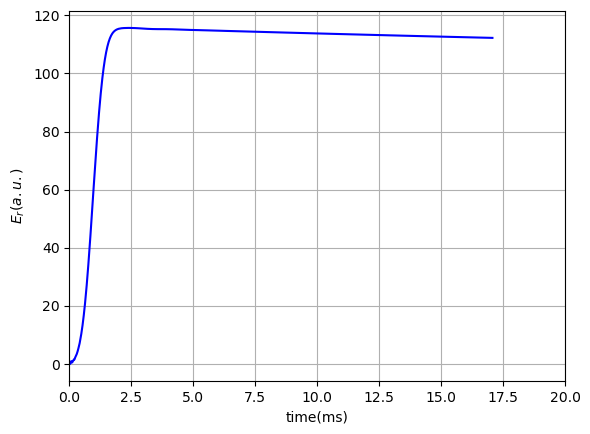

In [31]:
ts=np.arange(ninter)*dt*1E3
plt.plot(ts,volintesf_10[0,0,:],'b')
plt.xlim(0,20)
plt.xlabel('time(ms)')
plt.ylabel(r'$E_r(a.u.)$')
plt.grid()
plt.show()

Figure: Time evolution of the vertical electric field for the global two-exponential conductivity profile of Table I. A vertical Gaussian current source is excited at ground level for $\theta$=90$^o$ and $\phi$=0$^o$, while output points are defined at ground level with $\theta$=0$^o$ and $\phi$=0.2$^o$. This is the case of the global two-exponential conductivity profile of Table I (profile code number=10).

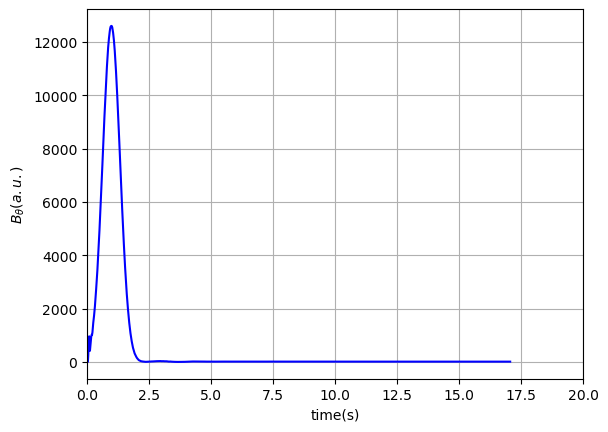

In [33]:
ts=np.arange(ninter)*dt*1E3
plt.plot(ts,volintesf_10[0,4,:]*1E3,'b')
plt.xlim(0,20)
plt.xlabel('time(s)')
plt.ylabel(r'$B_{\theta}(a.u.)$')
plt.grid()
plt.show()

Figure 5: Time evolution of the NS component of the magnetic field for the global two-exponential conductivity profile of Table I. A vertical Gaussian current source is excited at ground level for $\theta$=90º and $\phi$=0º, while output points are defined at ground level with $\theta$=45º and several values of $\phi$ from 0º to 180º. This is the case of the global two-exponential conductivity profile of Table I (profile code number=10).

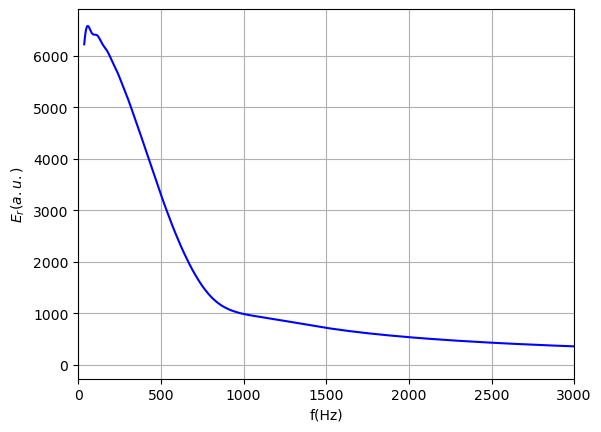

In [36]:
fs=frecs[10:]
plt.plot(fs,volintesf_df_10[0,0,10:],'b')
plt.xlim(0,3000)
plt.xlabel('f(Hz)')
plt.ylabel(r'$E_{r}(a.u.)$')
plt.grid()
plt.show()

Figure: Frequency-domain vertical component of the electric field in response to a Gaussian vertical current source excited at ground level for $\theta$=90$^o$ an $\phi$=0$^o$. Output points are defined at ground level for with $\theta$ =45$^o$ and $\phi$=0.2$^o$. This is the case of the global two-exponential conductivity profile of Table I (profile code number=10).

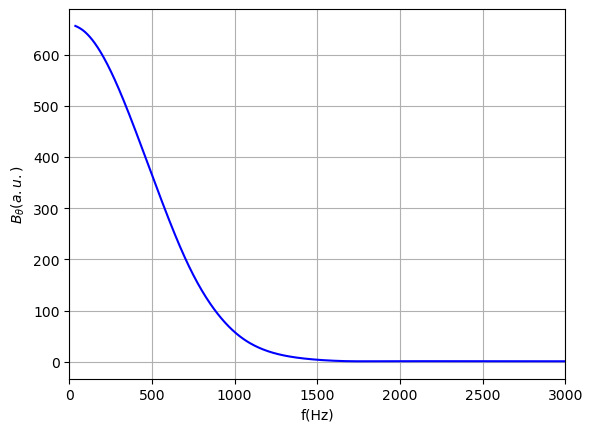

In [40]:
fs=frecs[10:]
plt.plot(fs,volintesf_df_10[0,4,10:],'b')
plt.xlabel('f(Hz)')
plt.xlim(0,3000)
plt.ylabel(r'$B_{\theta}(a.u.)$')
plt.grid()
plt.show()

Figure: Frequency-domain NS component of the magnetic field in response to a Gaussian vertical current source excited at ground level for $\theta$=90$^o$ an $\phi$=0$^o$. Output points are defined at ground level for with $\theta$ =45$^o$ and $\phi$=0.2$^o$. This is the case of the global two-exponential conductivity profile of Table I (profile code number=10).